# ADA Project: MileStone2

## While way-finding in information network, human is a *Genius* or a *Lazybone*?

*Wikipeedia* is a human-computation game based on articles in Wikipedia. Users are asked to navigate from a source article to a specific target one, through clicking the links appeared in each Wikipedia article. Different from how a computer plays the game, humans will not always choose the shortest path to reach the destination word from the source one.
We summary the human's "clicking process" into two main steps:
<ol>
<li>People first establish a logical chain (clear or blurry) which connect the source word to the destination, preliminarily. This part is based on people's priori knowledge.</li>
<br>
<li>While scanning the HTML page, people change their initial logical chain and finish their "clicking task". People make their shift according to the HTML they see, i.e. textplain, images in the page. </li>
</ol>

We will process our analyse according to this two steps. In the first part, we use the model LDA to grasp points about how people link the source and target. In the second stage, we analyze the finished path and unfinished path to find people's clicking tendency based on the article they scan.

### Content

1. Basic analysis on the dataset
2. Logical chain exploration using the LDA model
3. Clicking tendency based on HTML pages


### Useful libraries

In [1]:
# Utilitaries
import pandas as pd
import os

# Math
import numpy as np
from scipy import stats

# Plot
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns


%load_ext autoreload
%autoreload 2

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 100)

### Data Importation

We will import the data in file "paths_finished.tsv", "article.tsv", "categories.tsv" and "paths_finished.tsv" into DataFrame and we load "shortest-path-distance-matrix.txt" and store it as NxN matric where N is the number of the articles.

In [4]:
# Reading the 'paths_finished.tsv' file as a pandas dataframe
PATH_DATASET = "./data"
fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/paths_finished.tsv')
df_finished_path = pd.read_csv("./data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', comment = '#', header=None, names = ['hashedIpAddress','timestamp','durationInSec','path','rating'], encoding = 'UTF-8')

df_finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0


In [5]:
# Reading the 'categories.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/categories.tsv')
df_categories = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles','category'], encoding = 'UTF-8')
df_categories.head()

,articles,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_Countries
4,%C3%89douard_Manet,subject.People.Artists


In [70]:
# Reading the 'articles.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/articles.tsv')
df_article = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles'],encoding = 'UTF-8')
df_article.head()

,articles
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [8]:
## Reading the 'paths_unfinished.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/paths_unfinished.tsv')
df_unfinished_path = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['hashedIpAddress','timestamp','durationInSec','path','target','type'],encoding = 'UTF-8')
df_unfinished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [9]:
## shortest path matrix

shortest_dist_path = './data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt'
with open(shortest_dist_path, "r", encoding='utf-8') as f:
    txt_lines = [line.strip() for line in f.readlines()]
    del txt_lines[0:17]
shortest_dist_matrix = np.array(txt_lines)

### First glance at the data

We first analyse each file, respectively. And then we will merge files together to delve more points.

#### Analyse each file independently. We will generate more datas in the dataframe.
Files are "paths_finished.tsv" and "categories.tsv"

**1. paths_finished.tsv**

Dataframe **df_finished_path** variables in this section

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

We calculate the path length and store the value in column **path_length**. For example if the path is "Yagan; Ancient_Egypt; Civilization", the path length is 2.

In [19]:
def calculate_path_length(x):
    string_array = x.split(';')
    return len(string_array)-1

df_finished_path['path_length'] = df_finished_path['path'].apply(calculate_path_length)

We extract the source and the target word from the path and store them in column **source** and **destination**, respectively.

In [20]:
def path_source(x):
    string_array = x.split(';')
    return string_array[0]


def path_destination(x):
    string_array = x.split(';')
    return string_array[-1]

df_finished_path['source'] = df_finished_path['path'].apply(path_source)
df_finished_path['destination'] = df_finished_path['path'].apply(path_destination)

We construct the data "path pair". For example, if the path is "A; B; C", then the path pair will be [(A, B), (B, C)]

In [21]:
df_finished_path['path_pair'] = None

i = 0
path_pair_dict = {}
for index, row in df_finished_path['path'].items():
    string_path_pair = []
    string_array = row.split(";")
    for pair_index in range(len(string_array) - 1):
        string_pair = '(' + string_array[pair_index] + ', ' + string_array[pair_index + 1] + ')'
        string_path_pair.append(string_pair)
        path_pair_dict[string_pair] = path_pair_dict.get(string_pair, 0) + 1
    df_finished_path['path_pair'][i] = string_path_pair
    i += 1

In [22]:
df_finished_path.head(5)

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3,14th_century,Greece,"[(14th_century, Renaissance), (Renaissance, Ancient_Greece), (Ancient_Greece, Greece)]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona..."


Analyze the data in dataframe df_finished_path

##### Variable: path length

First, we anlyse the variable path_length. We draw the histogram of it.

Text(0.5, 1.0, 'Path Length Frequency Histogram')

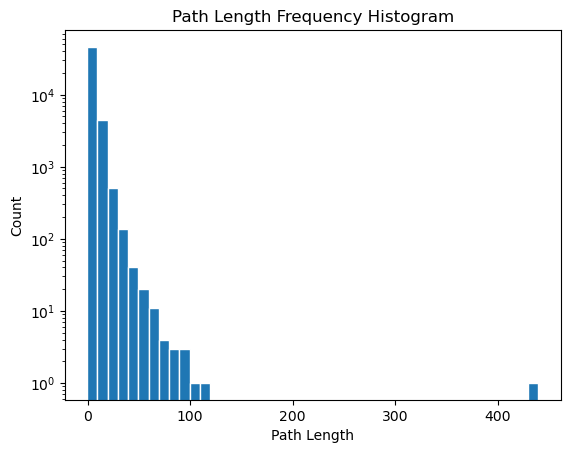

In [23]:
df_finished_path['path_length'].plot.hist(bins=np.arange(-0.5,440.5, 10), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram")

From the histogram, we could find that the path length mainly concentrates on the range(0, 100). There is also one outlier lying at 400+. In order to remove the special situations during the game playing, we set the range of bins to 10. And we consider that the path length frequency in each bin, which is smaller than 2, as outliers. We remove the path length larger than 100.


In [24]:
df_finished_path_rm_outlier = df_finished_path[df_finished_path['path_length'] <= 100]

We also find there are data whose path_length equals to 0. It means that the target article is same to to source one. We also remove this situation.

In [25]:
df_finished_path_rm_outlier = df_finished_path_rm_outlier[df_finished_path_rm_outlier['path_length'] != 0]

Text(0.5, 1.0, 'Path Length Frequency Histogram without Outliers')

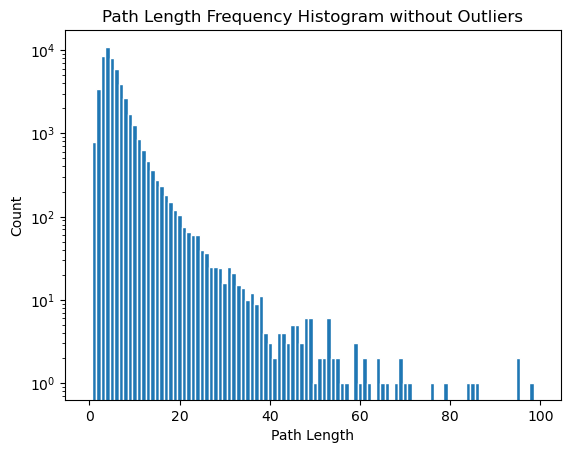

In [27]:
df_finished_path_rm_outlier['path_length'].plot.hist(bins=np.arange(-0.5,100.5,1), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram without Outliers")

##### Variable: rating and path_length

As we calculated the path lengths, we also want to find that whether the rate is related to the path length. We create a new Dataframe to store the rated paths.

In [29]:
## Is rating related to steps?

# use only data with rating
df_rate = df_finished_path_rm_outlier[df_finished_path_rm_outlier['rating']>0]

We draw the boxplot with the variable data path_length and rating.

In [37]:
print('Average steps for each rating')
for i in range(5):
    # calculate the intervals
    CI = stats.norm.interval(0.95, np.mean(df_rate[df_rate.rating == i+1].path_length), np.std(df_rate[df_rate.rating == i+1].path_length)/np.sqrt(len(df_rate[df_rate.rating == i+1].path_length)))
    print('rating =',i+1)
    print('number:',df_rate[df_rate.rating == i+1].path_length.count())
    print('mean:',df_rate[df_rate.rating == i+1].path_length.mean(),'\n95% CI:',CI)

Average steps for each rating
rating = 1
number: 8542
mean: 3.6661203465230625 
95% CI: (3.6225986640558583, 3.7096420289902667)
rating = 2
number: 8792
mean: 5.001592356687898 
95% CI: (4.950619800250819, 5.052564913124978)
rating = 3
number: 7261
mean: 6.645503374190882 
95% CI: (6.560040894779702, 6.730965853602063)
rating = 4
number: 2748
mean: 9.08296943231441 
95% CI: (8.863767675989052, 9.302171188639768)
rating = 5
number: 1156
mean: 11.852941176470589 
95% CI: (11.184158085458863, 12.521724267482314)


Text(0.5, 1.0, 'Boxplot of Path Length and Rating')

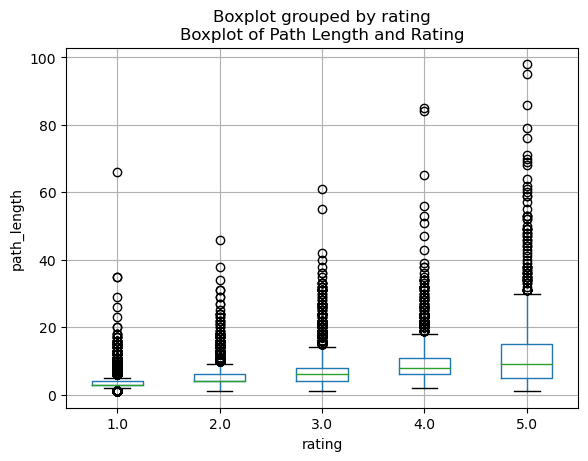

In [38]:
# df_rate.plot.scatter(x='steps', y='rating')
df_rate.boxplot(column=['path_length'], by=['rating'])
plt.xlabel("rating")
plt.ylabel("path_length")
plt.title("Boxplot of Path Length and Rating")

From the above plot, we find that the rating is related to the path length. And longer path will have a higher rate. We will delve this part in our later project.

**2. categories.tsv**

Dataframe **df_categories** variables

`articles`: the name of the article

`category`: the category that the article belongs to

`category_length`: the hierarchical depth of the variable category

`category_1st`: the 1st category that the article belongs to

We calculate the hierarchical depth of variable category

In [93]:
def calculate_category_length(x):
    string_array = x.split('.')
    return len(string_array)

df_categories['category_length'] = df_categories['category'].apply(calculate_category_length)

Since all of the articles with categories have the same root 'Subject', we firstly extract the 1st depth category and store the data in the column **category_1st**

In [94]:
df_categories['category_1st'] = df_categories.apply(lambda x:x.category.split('.')[1], axis = 1)

Analyze the data in dataframe df_categories

##### Variable: category_length

We first count the frequency according to the variable category_length. There are 274 articles which category depth equals to 2. 3448 articles which category depth equals to 3. 1482 articles which category depth equals to 4.

In [95]:
df_categories['category_length'].value_counts()

3    3448
4    1482
2     274
Name: category_length, dtype: int64

Then, we check the category with different depth in details.

In [96]:
category_dict_1 = {}
category_dict_2 = {}
category_dict_3 = {}

for index, row in df_categories['category'].items():
    string_path_pair = []
    string_array = row.split(".")
    for index in range(len(string_array)):
        if index == 1:
            category_dict_1[string_array[index-1] + "." + string_array[index]] = category_dict_1.get(string_array[index-1] + "." + string_array[index], 0) + 1
        elif index == 2:
            category_dict_2[string_array[index-2] + "." + string_array[index-1] + "." + string_array[index]] = category_dict_2.get(string_array[index-2] + "." + string_array[index-1] + "." + string_array[index], 0) + 1
        elif index == 3:
            category_dict_3[string_array[index-3] + "." + string_array[index-2] + "." + string_array[index-1] + "." + string_array[index]] = category_dict_3.get(string_array[index-3] + "." + string_array[index-2] + "." + string_array[index-1] + "." + string_array[index], 0) + 1

We check the categories at the depth 1. Key is the category and the value is the number of articles in this cateogory.

In [97]:
print("There are {} categories at depth 1".format(len(category_dict_1)))
category_dict_1

There are 15 categories at depth 1


{'subject.History': 545,
 'subject.People': 689,
 'subject.Countries': 229,
 'subject.Geography': 1084,
 'subject.Business_Studies': 88,
 'subject.Science': 1122,
 'subject.Everyday_life': 374,
 'subject.Design_and_Technology': 254,
 'subject.Music': 97,
 'subject.IT': 85,
 'subject.Language_and_literature': 196,
 'subject.Mathematics': 45,
 'subject.Religion': 134,
 'subject.Art': 38,
 'subject.Citizenship': 224}

We check the categories at the depth 2. Key is the category and the value is the number of articles in this cateogory.

In [42]:
print("There are {} categories at depth 2".format(len(category_dict_2)))
category_dict_2

There are 103 categories at depth 2


{'subject.History.British_History': 158,
 'subject.People.Historical_figures': 108,
 'subject.Geography.European_Geography': 139,
 'subject.People.Artists': 36,
 'subject.Business_Studies.Currency': 14,
 'subject.History.General_history': 80,
 'subject.History.Military_History_and_War': 71,
 'subject.Science.Physics': 226,
 'subject.Everyday_life.Sports_events': 22,
 'subject.Geography.Storms': 33,
 'subject.History.Recent_History': 48,
 'subject.Geography.Geology_and_geophysics': 76,
 'subject.Geography.Natural_Disasters': 39,
 'subject.Design_and_Technology.Railway_transport': 84,
 'subject.People.Sports_and_games_people': 45,
 'subject.Science.Biology': 704,
 'subject.Music.Performers_and_composers': 16,
 'subject.IT.Computing_hardware_and_infrastructure': 20,
 'subject.Business_Studies.Companies': 18,
 'subject.Language_and_literature.Novels': 39,
 'subject.Music.Musical_genres_styles_eras_and_events': 46,
 'subject.Everyday_life.Everyday_life': 27,
 'subject.Geography.Geography_of

We check the categories at the depth 3. Key is the category and the value is the number of articles in this cateogory.

In [43]:
print("There are {} categories at depth 3".format(len(category_dict_3)))
category_dict_3

There are 27 categories at depth 3


{'subject.History.British_History.British_History_1500_and_before_including_Roman_Britain': 73,
 'subject.Geography.European_Geography.European_Countries': 56,
 'subject.Science.Physics.Space_Astronomy': 105,
 'subject.Science.Biology.Health_and_medicine': 109,
 'subject.Science.Physics.General_Physics': 55,
 'subject.Science.Biology.Mammals': 114,
 'subject.Science.Biology.Plants': 108,
 'subject.History.British_History.British_History_15001750': 29,
 'subject.Geography.Geography_of_Asia.Asian_Countries': 37,
 'subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries': 18,
 'subject.Science.Chemistry.Chemical_compounds': 42,
 'subject.Science.Chemistry.Chemical_elements': 119,
 'subject.Science.Biology.General_Biology': 51,
 'subject.Science.Biology.Birds': 161,
 'subject.Science.Biology.Insects_Reptiles_and_Fish': 72,
 'subject.Science.Biology.Dinosaurs': 59,
 'subject.Science.Chemistry.General_Chemistry': 21,
 'subject.Geography.African_Geography.African_Countries': 5

##### Variable: categories

We will carry out some basic analysis to the variable category.

subject.Countries                               229
subject.Science.Biology.Birds                   161
subject.Geography.Geography_of_Great_Britain    124
subject.Science.Chemistry.Chemical_elements     119
subject.Science.Biology.Mammals                 114
subject.Science.Biology.Health_and_medicine     109
subject.Science.Biology.Plants                  108
subject.People.Historical_figures               108
subject.Science.Physics.Space_Astronomy         105
subject.Geography.North_American_Geography      103
Name: category, dtype: int64

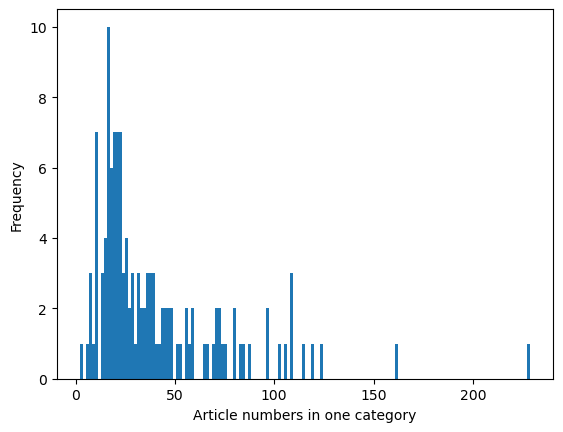

In [44]:
## how many categories are there in the dataframe

category_list = df_categories['category'].value_counts()
plt.hist(category_list,150)
plt.xlabel("Article numbers in one category")
plt.ylabel("Frequency")
category_list[:10]

**3. articles.tsv**

We mainly used this file to get the index of an article.
However, we can also anylize the articles by combining with categories.

In [51]:
## label every article with category

df_article_with_cate = pd.merge(df_article, df_categories, how = 'outer')
df_article_with_cate.head()

,articles,category,category_length
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,4.0
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,3.0
2,%C3%85land,subject.Countries,2.0
3,%C3%85land,subject.Geography.European_Geography.European_Countries,4.0
4,%C3%89douard_Manet,subject.People.Artists,3.0


In [52]:
# find articles without categories
df_article_with_cate[df_article_with_cate.isnull().T.any()]

,articles,category,category_length
1360,Directdebit,NaN,NaN
1385,Donation,NaN,NaN
1811,Friend_Directdebit,NaN,NaN
3670,Pikachu,NaN,NaN
4342,Sponsorship_Directdebit,NaN,NaN
5141,Wowpurchase,NaN,NaN


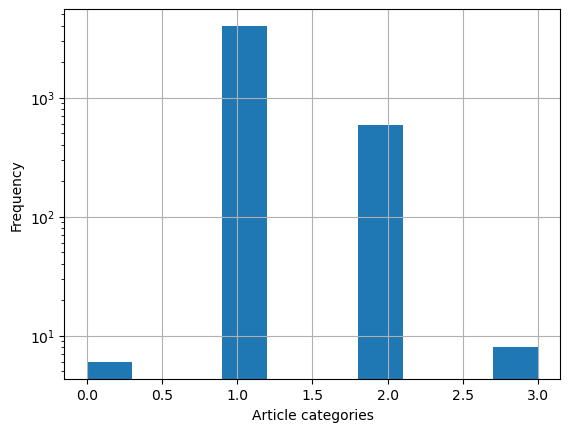

In [57]:
# find articles with multiple categories
dup_cate_list = df_article_with_cate.articles.value_counts()

# modify no category articles
dup_cate_list[df_article_with_cate[df_article_with_cate.isnull().T.any()].articles] = 0

dup_cate_list.hist()
plt.yscale('log')
plt.xlabel("Article categories")
plt.ylabel("Frequency")
plt.show()

**4. paths_unfinished.tsv**

We mainly analyze the unfinished paths by focusing on the quit type, path length and its target.

In [118]:
# different number of reason for unfinished
df_unfinished_path.type.value_counts()

restart    15552
timeout     9323
Name: type, dtype: int64

In [120]:
# count path lengths
df_unfinished_path['path_length'] = df_unfinished_path.apply(lambda x:x.path.count(';'),axis = 1)

Find out players restart without clicking any links

In [122]:
df_restart0 = df_unfinished_path[(df_unfinished_path.type == 'restart') & (df_unfinished_path.path_length == 0)]
df_restart0.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,path_length
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,0
8,6d136e371e42474f,1297102100,19,Logic,Moon_landing,restart,0
11,05dc2fbd5fc8d375,1297135100,8,Niobium,Beeching_Axe,restart,0
15,5900aa2d71b99153,1297138883,22,Prostate_cancer,Du_Fu,restart,0
20,3786d9852b814082,1297152708,13,Snowball_Earth,Medal_of_Honor,restart,0


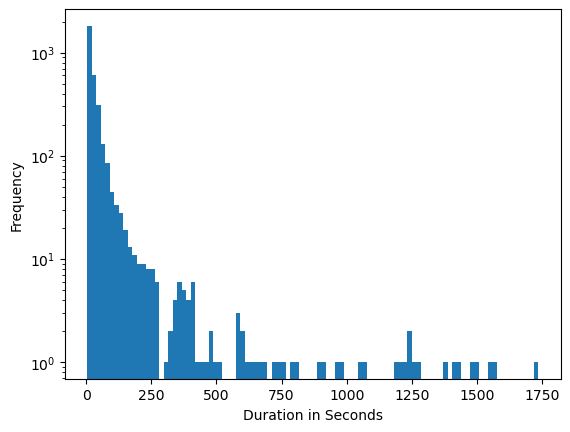

In [126]:
plt.hist(df_restart0.durationInSec,100)
plt.yscale('log')
plt.xlabel("Duration in Seconds")
plt.ylabel("Frequency")
plt.show()

We can see that most of players they quit without carefully viewing the article while a few players they might have read the article and then deciede to restart.

Then we can have a look on the target: with which target players are more likely to quit?


In [127]:
restart0_target_list = pd.DataFrame(data = df_restart0.target.value_counts(sort = True))
restart0_target_list = restart0_target_list[restart0_target_list.target > 10]
restart0_target_list

,target
Telephone,113
Zebra,105
Viking,66
Bean,62
Adolf_Hitler,26
Microsoft,19
Penguin,16
Wood,13
Krazy_Kat,12
Social_capital,12


Take the target show up frequency into consideration

In [128]:
restart0_target_list_total = pd.DataFrame(df_unfinished_path[df_unfinished_path['target'].isin(restart0_target_list.index)].target.value_counts(sort = True))
restart0_target_ratio = restart0_target_list/restart0_target_list_total
restart0_target_ratio.sort_values(by=['target'])

,target
Tiger_Woods,0.050459
Bean,0.065263
Viking,0.089918
Telephone,0.106604
Zebra,0.117581
Wood,0.139785
Banana,0.142857
Google,0.148148
Krazy_Kat,0.173913
The_Country_Wife,0.239130


It seems players are more likely to quit when they see Penguin as target.

All the above analysis focus more on seperate files and aim at giving a first impression of the datasets.

#### Merge Data in Files together. And Analyse the Dataset more comprehensively

```bash
A. Convert path to index number format
```

The path will be converted to number index in the column **pathnum**. We can first use the index to get the shortest path and make comparison. Also, this is useful when we later analyze in LDA construction.

In [74]:
## First modify the df_article to make it easier find index
# record index and change index to articles names
df_article_temp = df_article.copy(deep = True)
df_article_temp['num'] = df_article.index
df_article_temp.index = df_article['articles']

## add withdraw step '<' as 'article: -1'
df_article_temp.loc['<'] = -1

In [84]:
df_finished_path_rm_outlier['pathnum'] = df_finished_path_rm_outlier.apply(lambda x:df_article_temp.loc[x.path.split(';')[:]].num.tolist(), axis = 1)

In [87]:
df_finished_path_rm_outlier[['path','pathnum']].head()

,path,pathnum
0,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]"
1,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,"[10, 1433, 128, 379, 143]"
2,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,"[10, 2982, 2984, 694, 3755, 128, 379, 143]"
3,14th_century;Renaissance;Ancient_Greece;Greece,"[10, 3464, 241, 1793]"
4,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,"[10, 2183, 3529, 1836, 3542, 3342, 2266]"


With paths represent in numbers, we can also compare the length of the path with the shortest path length.

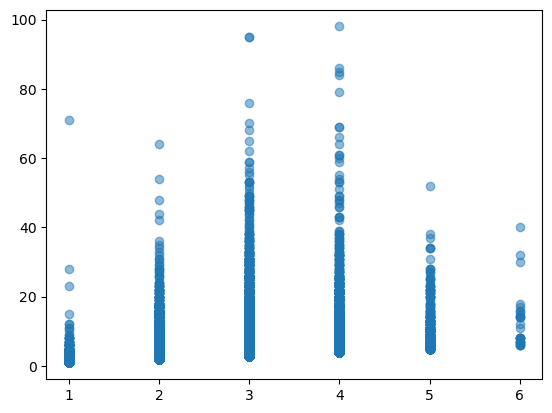

In [82]:
# add shortest path length to dataframe
df_finished_path_rm_outlier['shortest'] = df_finished_path_rm_outlier.apply(lambda x:shortest_dist_matrix[x['pathnum'][0]][x['pathnum'][-1]], axis = 1)

# temporately not consider the error in shortest path
df_finished_path_rm_outlier = df_finished_path_rm_outlier.drop(df_finished_path_rm_outlier[df_finished_path_rm_outlier['shortest'] == '_'].index, axis = 0)
# use 'int' type in shortest path length instead of 'string'
df_finished_path_rm_outlier['shortest'] = df_finished_path_rm_outlier.apply(lambda x: int(x.shortest), axis = 1)

# visualize
plt.scatter(df_finished_path_rm_outlier['shortest'], df_finished_path_rm_outlier['path_length'],alpha=0.5)

```bash
B. Analyze the finished_path dataframe joined with categories
```

Dataframe **df_finished_path** variables

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

`pathnum`: convert the path to path number index

`first_path`: article that the user first click on

`first_path_category`: category of the article that the user first click on

`first_path_category_length`: length of the variable first_path_category

`first_path_category_1st`: 1st category of the article that the user first click on

`source_category`: category of the source article

`source_category_length`: length of the variable source_category

`source_category_1st`: 1st category of the source article

`dest_category`: category of the destination article

`dest_category_length`: length of the variable dest_category

`dest_category_1st`: 1st category of the destination article

`source_dest_category_1st`: category pairs contain the category of source and destination articles

`source_first_path_category_1st`: category pairs contain the category of source and first clicking articles

First merge the df_finished_path and df_categories. Every data about the articles will have their category information.
First, we extract the first article that the user click and store the data in column **first_path**

In [99]:
df_merge_finished_path_category = df_finished_path_rm_outlier.copy(deep=True)
df_merge_finished_path_category['first_path'] = df_merge_finished_path_category.apply(lambda x:x.path.split(';')[1], axis = 1)

We merge the path and the category dataframe together. We create new columns called "first_category" and "first_category_length" to store the category information of the first path

In [100]:
df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories, left_on='first_path', right_on='articles')

In [101]:
df_merge_finished_path_category['first_path_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['first_path_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['first_path_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.first_path_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

We create new columns called "source_category" and "source_category_length" to store the category information of the source article. We create new columns called "dest_category" and "dest_category_length" to store the category information of the destination article.

In [102]:
df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories,left_on='source', right_on='articles')
df_merge_finished_path_category['source_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['source_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['source_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.source_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

df_merge_finished_path_category = pd.merge(df_merge_finished_path_category, df_categories,left_on='destination', right_on='articles')
df_merge_finished_path_category['dest_category'] = df_merge_finished_path_category['category']
df_merge_finished_path_category['dest_category_length'] = df_merge_finished_path_category['category_length']
df_merge_finished_path_category['dest_category_1st'] = df_merge_finished_path_category.apply(lambda x:x.dest_category.split('.')[1], axis = 1)
df_merge_finished_path_category = df_merge_finished_path_category.drop(['category','articles', 'category_length', 'category_1st'], axis = 1)

Then, we merge the source category with the destination category and store the data in column **source_dest_category**

In [103]:
df_merge_finished_path_category['source_dest_category_1st'] = df_merge_finished_path_category['source_category_1st'].str.cat(';' + df_merge_finished_path_category['dest_category_1st'])

In [104]:
df_merge_finished_path_category['source_dest_category'] = df_merge_finished_path_category['source_category'].str.cat(';' + df_merge_finished_path_category['dest_category'])

Then, we merge the source category with the first path category and store the data in column **source_first_path_category**

In [105]:
df_merge_finished_path_category['source_first_path_category_1st'] = df_merge_finished_path_category['source_category_1st'].str.cat(';' + df_merge_finished_path_category['first_path_category_1st'])

In [106]:
df_merge_finished_path_category.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair,pathnum,shortest,first_path,first_path_category,first_path_category_length,first_path_category_1st,source_category,source_category_length,source_category_1st,dest_category,dest_category_length,dest_category_1st,source_dest_category_1st,source_dest_category,source_first_path_category_1st
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac...","[10, 12, 15, 3134, 377, 105, 128, 379, 143]",3,15th_century,subject.History.General_history,3,History,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,subject.History.General_history;subject.History.General_history,History;History
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade...","[10, 1433, 128, 379, 143]",3,Europe,subject.Geography.European_Geography,3,Geography,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,subject.History.General_history;subject.History.General_history,History;Geography
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]",3,Niger,subject.Geography.African_Geography.African_Countries,4,Geography,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,subject.History.General_history;subject.History.General_history,History;Geography
3,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ...","[10, 2982, 2984, 694, 3755, 128, 379, 143]",3,Niger,subject.Countries,2,Countries,subject.History.General_history,3,History,subject.History.General_history,3,History,History;History,subject.History.General_history;subject.History.General_history,History;Countries
4,753ed9952cc780aa,1308004822,114,Bread;Ethiopia;Africa;Atlantic_slave_trade;African_slave_trade,1.0,4,Bread,African_slave_trade,"[(Bread, Ethiopia), (Ethiopia, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade, A...","[685, 1420, 128, 379, 143]",3,Ethiopia,subject.Geography.African_Geography.African_Countries,4,Geography,subject.Everyday_life.Food_and_agriculture,3,Everyday_life,subject.History.General_history,3,History,Everyday_life;History,subject.Everyday_life.Food_and_agriculture;subject.History.General_history,Everyday_life;Geography


Analyze the data in dataframe df_merge_finished_path_category

##### Variable: first_path_category_1st

We count the frequency of variable **first_path_category_1st**. For example, the result shows that people click the article which is in the Science category 13672 times during the whole finished path.

In [107]:
click_category_count_depth1 = df_merge_finished_path_category['first_path_category_1st'].value_counts(sort = True)
click_category_count_depth1

Geography                  35068
Countries                  17663
Science                    13672
History                     6959
Citizenship                 4066
Everyday_life               3841
Language_and_literature     3133
People                      3094
Religion                    2119
IT                          1235
Business_Studies            1076
Design_and_Technology       1062
Music                        479
Mathematics                  403
Art                          360
Name: first_path_category_1st, dtype: int64

Then, we compare the result above with the article numbers in each category. For example, there are 38 articles in the category Art. And when people play the game, there are 360 times that people choose the Art category in their first choice.

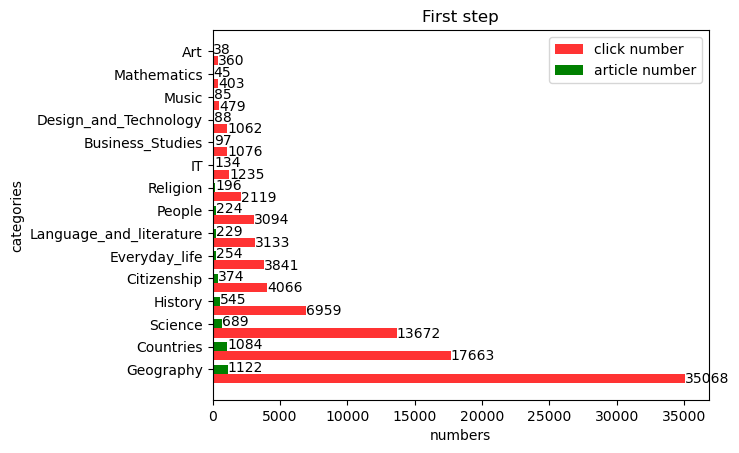

In [108]:
y = range(len(click_category_count_depth1))
catagory_values = df_categories['category_1st'].value_counts(sort = True)

rects1 = plt.barh(y=y, width=click_category_count_depth1, height=0.4, alpha=0.8, color='red', label="click number")
rects2 = plt.barh(y=[i + 0.4 for i in y], width=catagory_values, height=0.4, color='green', label="article number")

plt.xlabel("numbers")

plt.yticks([index + 0.4 for index in y], click_category_count_depth1.index)
plt.ylabel("categories")
plt.title("First step")
plt.legend()

for rect in rects1:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 - 0.2, str(width))
for rect in rects2:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 - 0.1, str(width))
plt.show()

We draw the picture which shows the ratio of article numbers in each category and the times that people choose article in this kind of category in their first choice.

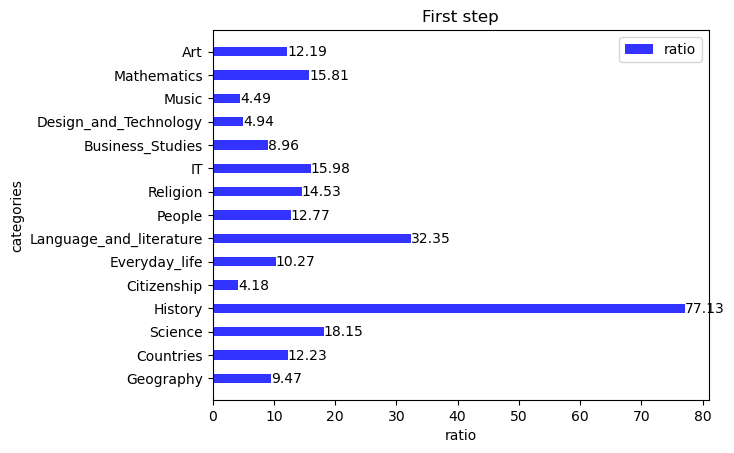

In [109]:
# ratio

rects3 = plt.barh(y=y, width = round(click_category_count_depth1/catagory_values,2), height=0.4, alpha=0.8, color='blue', label="ratio")
plt.xlabel("ratio")

plt.yticks([index  for index in y], click_category_count_depth1.index)
plt.ylabel("categories")
plt.title("First step")
plt.legend()

for rect in rects3:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2 -0.2, str(width))

plt.show()

From the picture, we find that the ratio of category history is relatively high, comparing with other categories. It means that people tends to click on the article with category "history" in their first clicking choice.
Then in the later project, we could focus on the HTML in history category to find the reason why people tends to choose this kind of article.

##### Variable: source_first_path_category

Then, we get the statistic of category pairs. The category pairs contains the category of source articles and the category of articles that people choose first in their clicking process. We can get a overviwe of the top10 category links. Also, this is affect by the number of articles in the categories. We can further analyze with this in the future.

In [110]:
click_category_count_depth1_source_first_path = df_merge_finished_path_category['source_first_path_category_1st'].value_counts(sort = True)
click_category_count_depth1_source_first_path[0:10]

Science;Science                      8987
Geography;Geography                  8521
Science;Geography                    6214
People;Geography                     3848
Everyday_life;Geography              3586
Geography;Countries                  3558
History;Geography                    2968
Science;Countries                    2764
Countries;Geography                  2158
Language_and_literature;Geography    2126
Name: source_first_path_category_1st, dtype: int64

##### Variable: source_dest_category_1st

Similarly, we get the statistic of category pairs. The category pairs contains the category of source articles and the category of destination articles.

In [111]:
click_category_count_depth1_source_dest = df_merge_finished_path_category['source_dest_category_1st'].value_counts(sort = True)
click_category_count_depth1_source_dest[0:10]

Science;Geography                  4600
Geography;Geography                4520
Science;Science                    4035
Language_and_literature;Science    3617
Science;History                    3492
Geography;Science                  3342
People;Geography                   2447
Everyday_life;Science              2326
Science;People                     2289
Everyday_life;Geography            1960
Name: source_dest_category_1st, dtype: int64

##### Variable: path_pair

We analyse the variable **path pair**. The path pair with the highest frequency will be found. And in the later project, we will delve the reason why people tends to follow on those path pair.

In [112]:
sorted(path_pair_dict.items(), key=lambda x: x[1], reverse=True)[:10]

[('(<, <)', 4971),
 ('(Communication, Telephone)', 533),
 ('(North_America, United_States)', 492),
 ('(Animal, Mammal)', 487),
 ('(Lion, Zebra)', 472),
 ('(United_States, President_of_the_United_States)', 469),
 ('(Europe, United_Kingdom)', 467),
 ('(Mammal, Zebra)', 450),
 ('(Brain, Computer_science)', 448),
 ('(<, United_States)', 436)]

From the above result, we find that the top-10 highest frequency path pair in our data. We could scan the HTML to find the reason why people always construct this kind of link during their game.
For example, we could first analyse the path pair with the required source and destination articles.

In [113]:
df_temp = df_merge_finished_path_category[df_merge_finished_path_category['path_pair'].str.contains("(Brain, Computer_science)", regex=False)]

In [115]:
df_temp['source_dest_category_1st'].value_counts()[:10]

Science;Design_and_Technology                    426
Science;IT                                        11
Science;Science                                    3
Science;Mathematics                                2
Science;Everyday_life                              2
Science;Business_Studies                           1
Religion;Everyday_life                             1
Religion;Mathematics                               1
People;Everyday_life                               1
Design_and_Technology;Language_and_literature      1
Name: source_dest_category_1st, dtype: int64

We could find that the path pair (Brain, Computer_science) always occur when the source and destination category is (Science; Design_and_Technology)

Then, we could continue to delve the source and destination articles. The specific detailed category of source and destination, which contains the path pair, is **subject.Science.Biology.General_Biology;subject.Design_and_Technology.Engineering**. So, later, we could find the specific articles to find the reason why people think the path pair (Brain, Computer_science) could help their tasks.

In [116]:
df_temp['source_dest_category'].value_counts()[:10]

subject.Science.Biology.General_Biology;subject.Design_and_Technology.Engineering           424
subject.Science.Biology.General_Biology;subject.IT.Computing_hardware_and_infrastructure      6
subject.Science.Biology.Mammals;subject.IT.Computing_hardware_and_infrastructure              3
subject.Science.Biology.Health_and_medicine;subject.Mathematics                               2
subject.Science.Biology.Mammals;subject.Design_and_Technology.Engineering                     2
subject.Science.Biology.General_Biology;subject.Everyday_life.Television                      2
subject.Science.Biology.Mammals;subject.Business_Studies.Companies                            1
subject.Science.Biology.Mammals;subject.IT.Software                                           1
subject.Science.Biology.Mammals;subject.Science.Physics.Electricity_and_Electronics           1
subject.Religion.Philosophy;subject.Everyday_life.Everyday_life                               1
Name: source_dest_category, dtype: int64

In [257]:
df_merge_finished_path_category[df_merge_finished_path_category.path.str.contains('Pikachu', regex=False)]

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair,pathnum,first_path,first_path_category,first_path_category_length,first_path_category_1st,source_category,source_category_length,source_category_1st,dest_category,dest_category_length,dest_category_1st,source_dest_category_1st,source_first_path_category_1st,source_dest_category
38985,1a60ec2436f556b0,1354167936,226,Whale;Japan;Nintendo;Computer_and_video_games;Pac-Man;Pikachu;Pok%C3%A9mon_Trading_Card_Game,4.0,6,Whale,Pok%C3%A9mon_Trading_Card_Game,"[(Whale, Japan), (Japan, Nintendo), (Nintendo, Computer_and_video_games), (Computer_and_video_ga...","[4462, 2226, 2991, 1007, 3132, 3253, 3284]",Japan,subject.Geography.Geography_of_Asia.Asian_Countries,4,Geography,subject.Science.Biology.Mammals,4,Science,subject.Everyday_life.Games,3,Everyday_life,Science;Everyday_life,Science;Geography,subject.Science.Biology.Mammals;subject.Everyday_life.Games
38986,1a60ec2436f556b0,1354167936,226,Whale;Japan;Nintendo;Computer_and_video_games;Pac-Man;Pikachu;Pok%C3%A9mon_Trading_Card_Game,4.0,6,Whale,Pok%C3%A9mon_Trading_Card_Game,"[(Whale, Japan), (Japan, Nintendo), (Nintendo, Computer_and_video_games), (Computer_and_video_ga...","[4462, 2226, 2991, 1007, 3132, 3253, 3284]",Japan,subject.Countries,2,Countries,subject.Science.Biology.Mammals,4,Science,subject.Everyday_life.Games,3,Everyday_life,Science;Everyday_life,Science;Countries,subject.Science.Biology.Mammals;subject.Everyday_life.Games
